# Constructing a KG for similarity in the P279 graph

This notebook explores the idea that Wikidata has significant useful information in the properties defined in classes.
For example, in `motor car (Q1420)` https://kgtk.isi.edu/browser/Q1420, we see infomration about the parts of a car, its effects, etc.
In `sports car (Q274586)` none of this information is present, but the information about `motor car` is applicable.
The notebook inherits down the properties defined in super-classes to sub-classes.
Unfortunately, it does not make sense to inherit down all properties and all values, and the problem is made more difficult because the class hierachy in Wikidata is skewed towards domains such as biology, which contain the majority of classes.

The notebook constructs a subgraph of wikidata containing only classes,removes many classes related to biology, removes properties that clearly don't make sense, and removes very generic values that does not make sense to inherit down.
The constructed graph also omits `instance of (P31)` and `subclass of (P279)`, as I am intersting in studying the usefulness of the other properties to describe classes.
The resulting graph has an average out-degree of 68, compared to 1.5 for the original graph.

The notebook shows:
- the procedure to construct the graph
- metrics in the new graph
- visualizations of the augmented and original graph
- examples of properties for a few items

Outputs:
- The new graph in $OUT/p279-graph.no.science.less-bio.x2.tsv.gz
- Statistics of properties in $OUT/property-counts.tsv
- Statistics of the values of properties in $OUT/node2-counts.tsv



### Preamble: set up the environment and files used in the tutorial

In [1]:
import io
import os
import subprocess
import sys

import numpy as np
import pandas as pd
from IPython.display import display, HTML

from graph_tool.all import *
import papermill as pm

from kgtk.configure_kgtk_notebooks import ConfigureKGTK
from kgtk.functions import kgtk, kypher

In [2]:
# Parameters
kgtk_path = "/Users/pedroszekely/Documents/GitHub/kgtk"

# Folder on local machine where to create the output and temporary folders
input_path = "/Volumes/GoogleDrive/Shared drives/KGTK/datasets/wikidata-20210215/data/"
input_path = "/Volumes/GoogleDrive/Shared drives/KGTK/datasets/wikidata-20210215-dwd-v2/"
output_path = "/Users/pedroszekely/Downloads/kypher/projects"
graph_cache_path = "/Volumes/crucial/wikidata-cache/wikidata.sqlite3.db"
project_name = "p279-similarity"

Our Wikidata distribution partitions the knowledge in Wikidata into smaller files that make it possible for you to pick and choose which files you want to use. Our tutorial KG is a subset of Wikidata, and is partitioned in the same way as the full Wikidata. The following is a partial list of all the files:

In [3]:
files = [
    "claims",
    "datatypes",
    "p279",
    "p279star",
    "p31"
]
ck = ConfigureKGTK(files, kgtk_path=kgtk_path)
ck.configure_kgtk(input_graph_path=input_path,
                  output_path=output_path,
                  graph_cache_path=graph_cache_path,
                  project_name=project_name,
                  debug=True
                 )

User home: /Users/pedroszekely
Current dir: /Users/pedroszekely/Documents/GitHub/kgtk-tutorial-files/use-cases
KGTK dir: /Users/pedroszekely/Documents/GitHub/kgtk
Use-cases dir: /Users/pedroszekely/Documents/GitHub/kgtk/use-cases


The KGTK setup command defines environment variables for all the files so that you can reuse the Jupyter notebook when you install it on your local machine.

In [4]:
ck.print_env_variables()

kypher: kgtk --debug query --graph-cache /Volumes/crucial/wikidata-cache/wikidata.sqlite3.db
OUT: /Users/pedroszekely/Downloads/kypher/projects/p279-similarity
USE_CASES_DIR: /Users/pedroszekely/Documents/GitHub/kgtk/use-cases
EXAMPLES_DIR: /Users/pedroszekely/Documents/GitHub/kgtk/examples
KGTK_LABEL_FILE: /Volumes/GoogleDrive/Shared drives/KGTK/datasets/wikidata-20210215-dwd-v2//labels.en.tsv.gz
GRAPH: /Volumes/GoogleDrive/Shared drives/KGTK/datasets/wikidata-20210215-dwd-v2/
TEMP: /Users/pedroszekely/Downloads/kypher/projects/p279-similarity/temp.p279-similarity
KGTK_OPTION_DEBUG: false
KGTK_GRAPH_CACHE: /Volumes/crucial/wikidata-cache/wikidata.sqlite3.db
STORE: /Volumes/crucial/wikidata-cache/wikidata.sqlite3.db
kgtk: kgtk --debug
claims: /Volumes/GoogleDrive/Shared drives/KGTK/datasets/wikidata-20210215-dwd-v2//claims.tsv.gz
datatypes: /Volumes/GoogleDrive/Shared drives/KGTK/datasets/wikidata-20210215-dwd-v2//metadata.property.datatypes.tsv.gz
p279: /Volumes/GoogleDrive/Shared dri

Tell SQLite where to create the temp files

In [5]:
os.environ['SQLITE_TMPDIR'] = "/Volumes/crucial/kypher/sqlite/temp"

In [6]:
%%time
ck.load_files_into_cache()

kgtk --debug query --graph-cache /Volumes/crucial/wikidata-cache/wikidata.sqlite3.db -i "/Volumes/GoogleDrive/Shared drives/KGTK/datasets/wikidata-20210215-dwd-v2//claims.tsv.gz" --as claims  -i "/Volumes/GoogleDrive/Shared drives/KGTK/datasets/wikidata-20210215-dwd-v2//metadata.property.datatypes.tsv.gz" --as datatypes  -i "/Volumes/GoogleDrive/Shared drives/KGTK/datasets/wikidata-20210215-dwd-v2//derived.P279.tsv.gz" --as p279  -i "/Volumes/GoogleDrive/Shared drives/KGTK/datasets/wikidata-20210215-dwd-v2//derived.P279star.tsv.gz" --as p279star  -i "/Volumes/GoogleDrive/Shared drives/KGTK/datasets/wikidata-20210215-dwd-v2//derived.P31.tsv.gz" --as p31  --limit 3
[2021-11-20 11:36:42 query]: SQL Translation:
---------------------------------------------
  SELECT *
     FROM graph_1 AS graph_1_c1
     LIMIT ?
  PARAS: [3]
---------------------------------------------
id	node1	label	node2	rank	node2;wikidatatype
P10-P1628-32b85d-7927ece6-0	P10	P1628	"http://www.w3.org/2006/vcard/ns#Video

Create custom indices for Wikidata files to improve query efficiency

In [7]:
!kgtk --debug query -i claims --idx mode:graph -i p279star --idx mode:monograph --limit 3

[2021-11-14 16:43:11 query]: SQL Translation:
---------------------------------------------
  SELECT *
     FROM graph_1 AS graph_1_c1
     LIMIT ?
  PARAS: [3]
---------------------------------------------
id	node1	label	node2	rank	node2;wikidatatype
P10-P1628-32b85d-7927ece6-0	P10	P1628	"http://www.w3.org/2006/vcard/ns#Video"	normal	url
P10-P1628-acf60d-b8950832-0	P10	P1628	"https://schema.org/video"	normal	url
P10-P1629-Q34508-bcc39400-0	P10	P1629	Q34508	normal	wikibase-item


In [8]:
# command to clear the indices and to recreate them
# !kgtk --debug query -i claims --idx mode:clear mode:graph -i p279star --idx mode:clear mode:monograph --limit 5

### Compute a graph of classes and properties between them

Extract the P279 graph. `entity (Q35120)`

In [9]:
kgtk("""
    query -i p279star -i claims
        --match '
            p279star: (class1)-[]->(:Q35120),
            p279star: (class2)-[]->(:Q35120),
            claims: (class1)-[edge_id {label: property}]->(class2)'
        --return 'distinct class1 as node1, property as label, class2 as node2'
        --order-by 'class1, property, class2'
    / add-id --id-style wikidata
    -o $OUT/p279-graph.tsv.gz
""")

Load the P279 in the cache

In [10]:
kgtk("query -i $OUT/p279-graph.tsv.gz --as p279graph --limit 3")

node1 label     node2                        id
0  Q100000030  P279    Q14748    Q100000030-P279-Q14748
1  Q100000058  P186    Q22731    Q100000058-P186-Q22731
2  Q100000058  P279  Q1622444  Q100000058-P279-Q1622444

Compute the counts of properties in the P279 graph

In [11]:
kgtk("""
    query -i $OUT/p279-graph.tsv.gz --as p279graph
        --match '(n1)-[edge_id {label: property}]->(n2)'
        --return 'distinct property as node1, "P1963computed" as label, count(edge_id) as node2'
        --order-by 'cast(node2, int) desc'
        -o $TEMP/p279-graph.property.tsv
""")

### Filter out properties that are subclass of `Wikidata property related to science (Q61058429)` as well as `P31` and `P279`

In [12]:
kgtk("""
    query -i claims -i p279star -i p279graph 
        --match '
            p279graph: (n1)-[edge_id {label: property}]->(n2),
            claims: (property)-[:P31]->(property_class),
            p279star: (property_class)-[:P279star]->(:Q61058429)'
        --return 'distinct property as id'
        -o $TEMP/science-property.tsv
""")

Remove from the P279 graph the science properties and P279

In [13]:
kgtk("""
    ifnotexists -i $TEMP/p279-graph.property.tsv --filter-on $TEMP/science-property.tsv 
        --mode NONE --input-keys node1 --filter-keys id
    / select-columns --columns node1 --mode NONE
    / filter -p 'P279, P31;;' --invert True --mode NONE
   -o $TEMP/properties.keep.tsv
""")

In [14]:
kgtk("""
    ifexists -i $OUT/p279-graph.tsv.gz --filter-on $TEMP/properties.keep.tsv
        --mode NONE --input-keys label --filter-keys node1
   -o $OUT/p279-graph.no.science.tsv.gz
""")

### Remove uninteresting classes:
- `protein (Q8054)`, 
- `cardinal cell part (Q66557947)`, 
- `macromolecular conformation (Q97669203)`
- `molecular function (Q14860489)`
- `gene product (Q424689)`
- `macromolecule (Q178593)`
- `biomolecule (Q206229)`

In [15]:
kgtk("""
    query -i p279star
        --match '(class)-[:P279star]->(node2)'
        --where 'node2 in ["Q66557947", "Q8054", "Q97669203", "Q14860489", "Q424689", "Q178593", "Q206229"]'
        --return 'distinct class as id'
    -o $TEMP/bio-stuff.tsv.gz
""")

In [16]:
!zcat < $TEMP/bio-stuff.tsv.gz | wc -l

 1866273


In [17]:
!zcat < $OUT/p279-graph.no.science.tsv.gz | wc -l

  566106


In [18]:
kgtk("""
    ifnotexists -i $OUT/p279-graph.no.science.tsv.gz --filter-on $TEMP/bio-stuff.tsv.gz
        --mode NONE --input-keys node1 --filter-keys id
    / ifnotexists --filter-on $TEMP/bio-stuff.tsv.gz 
        --mode NONE --input-keys node2 --filter-keys id
    -o $OUT/p279-graph.no.science.less-bio.tsv.gz
""")

In [19]:
!zcat < $OUT/p279-graph.no.science.less-bio.tsv.gz | wc -l

  210059


In [20]:
!kgtk filter -i $OUT/p279-graph.no.science.less-bio.tsv.gz -p ';;Q100347974'

node1	label	node2	id


In [21]:
kgtk("head -i $OUT/p279-graph.no.science.less-bio.tsv.gz / add-labels")

node1  label      node2                       id  \
0    Q1000300   P156    Q908027    Q1000300-P156-Q908027   
1    Q1000349   P361    Q163829    Q1000349-P361-Q163829   
2    Q1000415   P641      Q5367      Q1000415-P641-Q5367   
3    Q1000492   P136   Q1643932   Q1000492-P136-Q1643932   
4    Q1000501   P366   Q1622008   Q1000501-P366-Q1622008   
5  Q100052938  P1074     Q35694  Q100052938-P1074-Q35694   
6    Q1000616   P641       Q542       Q1000616-P641-Q542   
7    Q1000660  P1889   Q2030545  Q1000660-P1889-Q2030545   
8    Q1000732   P155  Q10352191  Q1000732-P155-Q10352191   
9    Q1000732   P156   Q1407659   Q1000732-P156-Q1407659   

                     node1;label               label;label  \
0         'Land Rover Series'@en          'followed by'@en   
1                            NaN              'part of'@en   
2                 'Henry 180'@en                'sport'@en   
3                 'adventure'@en                'genre'@en   
4  'material flow controller'@en                  'use'@en   
5          'fictional jaguar'@en  'fictional analog of'@en   
6         'Budapest Marathon'@en                'sport'@en   
7      'algebra over a field'@en       'different from'@en   
8               'Ferrari GT4'@en              'follows'@en   
9               'Ferrari GT4'@en          'followed by'@en   

                       node2;label  
0  'Land Rover Defender (L316)'@en  
1                 'synthesizer'@en  
2                  'motorsport'@en  
3  'tabletop role-playing game'@en  
4          'high bay warehouse'@en  
5               'Panthera onca'@en  
6                   'athletics'@en  
7         'algebra over a ring'@en  
8            'Ferrari Dino 246'@en  
9                 'Ferrari 308'@en

### Copy properties down to subclasses

Copying properties from the very abstract classes seems to introduce noise: the meaning of some properties change as they are copied down. For example, `said to be the same as (P460)` changes meaning into "closely related to", and the more distant from the origin, the less closely related it gets.

We have to make sure we don't reintroduce classes that we removed in the previous steps.

In [22]:
kgtk("""
    query -i $OUT/p279-graph.no.science.less-bio.tsv.gz -i p279star
        --match '
            graph: (class)-[l {label: property}]->(n2),
            graph: (subclass)-[]->(),
            p279star: (subclass)-[:P279star]->(class)'
        --return 'distinct subclass as node1, property as label, n2 as node2'
        -o $OUT/p279-graph.no.science.less-bio.x.tsv.gz
""")

In [23]:
!zcat < $OUT/p279-graph.no.science.less-bio.x.tsv.gz | wc -l

 14158357


In [24]:
!zcat < $OUT/p279-graph.tsv.gz | wc -l

 13347573


Count the number of node1's in the final graph

In [25]:
kgtk("""
    query -i $OUT/p279-graph.no.science.less-bio.x.tsv.gz 
        --match '(node)-[]->()' 
        --return 'count(distinct node)'
""")

count(DISTINCT graph_21_c1."node1")
0                               125111

### Compute the distribution of Value counts, i.e., the values in node2.

In [26]:
kgtk("""
    query -i $OUT/p279-graph.no.science.less-bio.x.tsv.gz 
        --match '(node)-[l {label: property}]->(n2)' 
        --return 'distinct n2 as node1, count(distinct node) as count'
        --order-by 'count desc' 
    / add-labels 
    -o $OUT/node2-counts.tsv
""")

Some of the entities that appear as node2 in the graph are very generic and don't want to have them.

In [27]:
kgtk("head -i $OUT/node2-counts.tsv -n 50")

node1   count                    node1;label
0    Q77468620  125111    'psychology terminology'@en
1    Q64728693  125111       'non-existent entity'@en
2      Q468777  125111                 'existence'@en
3    Q32753077  125111           'Wikidata entity'@en
4      Q324254  125111                  'ontology'@en
5      Q190995  125111                   'essence'@en
6      Q154242  125111                   'nothing'@en
7      Q488383  113994                    'object'@en
8    Q17334923  110654                  'location'@en
9     Q3505845  109206                     'state'@en
10       Q5891   96551                'philosophy'@en
11     Q937228   88411                  'property'@en
12    Q4406616   82524           'concrete object'@en
13   Q96251598   82380            'type of object'@en
14     Q830077   82379                   'subject'@en
15   Q20203727   82378       'mythological object'@en
16   Q15706911   82378          'fictional object'@en
17          Q5   80689                     'human'@en
18   Q29651519   78908             'mental object'@en
19     Q223557   68618           'physical object'@en
20   Q29651224   63739            'natural object'@en
21     Q386724   63599                      'work'@en
22   Q14623823   63553             'artificiality'@en
23     Q186408   63484             'point in time'@en
24    Q7184903   61626           'abstract object'@en
25        Q413   61012                   'physics'@en
26    Q2668072   60983                'collection'@en
27   Q36809769   60800           'object of group'@en
28      Q36161   59392                       'set'@en
29    Q1514741   59304                       'set'@en
30      Q35120   56957                    'entity'@en
31    Q4373292   56743         'physical property'@en
32   Q18195733   56311            'concretization'@en
33      Q11423   55437                      'mass'@en
34   Q63341786   55359                       'set'@en
35   Q36808958   55359            'element of set'@en
36     Q937946   55280              'solid figure'@en
37      Q11438   55273                     'solid'@en
38      Q58778   55188                    'system'@en
39     Q126695   55188  'universal quantification'@en
40   Q41792217   55186         'number of objects'@en
41   Q20937557   55183                    'series'@en
42   Q12139612   55183                      'list'@en
43      Q83478   55182                     'group'@en
44      Q83306   55180                     'group'@en
45    Q1454986   54844           'physical system'@en
46      Q36253   54840                    'length'@en
47     Q128709   54831                 'viscosity'@en
48     Q208826   54801                    'height'@en
49  Q101490283   54793              'corporeality'@en

Let's remove the top 50 and see what we get.
> We should probably curate the list by hand

In [28]:
kgtk("""
    head -i $OUT/node2-counts.tsv -n 50
    / select-columns -c node1 --mode NONE
    -o $TEMP/banned-node2.tsv
""")

Use `ifnotexists` to remove the node2's that we don't want

In [29]:
kgtk("""
    ifnotexists -i $OUT/p279-graph.no.science.less-bio.x.tsv.gz  --filter-on $TEMP/banned-node2.tsv
        --mode NONE --input-keys node2 --filter-keys node1
    -o $OUT/p279-graph.no.science.less-bio.x2.tsv.gz
""")

In [30]:
!zcat < $OUT/p279-graph.no.science.less-bio.x2.tsv.gz | wc -l

 9785140


### Run connected components to see what we get

In [31]:
kgtk("""
    connected-components -i $OUT/p279-graph.no.science.less-bio.tsv.gz -o $OUT/p279-graph.no.science.less-bio.components.tsv.gz
""")

Look at the components. We have a large component and many thousands of isolated islands.

In [64]:
kgtk("""
    unique -i $OUT/p279-graph.no.science.less-bio.components.tsv.gz -c node2
    / sort -c node2 --numeric True --reverse True
""")

node1  label   node2
0      CLUSSEjI4DXlEZfRUhe+QerPrg==  count  100528
1      CLUSPb0cXsS1W+1C2YJOd/leOw==  count     140
2      CLUS1gaLYuS7BA/RKGtAU4yNPw==  count     135
3      CLUSjJfgjQ47pVWH0IABcShQjg==  count     114
4      CLUS9huVKxTVzREy+1YcyRyybA==  count     114
...                             ...    ...     ...
13696  CLUS+/WyCsbg0g1D/Xmr4FT2rg==  count       2
13697  CLUS+/WPTiniFZvOIQFHO0Zm6g==  count       2
13698  CLUS++zeSOSSynuCtTxB6xqoSA==  count       2
13699  CLUS++nL2R8G1e4tN/pU5iKuPg==  count       2
13700  CLUS++i/UrVvKyDcrpjrTRoM/Q==  count       2

[13701 rows x 3 columns]

See what is in one of the components

In [65]:
kgtk("""
    filter -i $OUT/p279-graph.no.science.less-bio.components.tsv.gz -p ';;CLUSSEjI4DXlEZfRUhe+QerPrg=='
    / head 
    / add-labels
""")

node1                label                         node2  \
0   Q100026  connected_component  CLUSSEjI4DXlEZfRUhe+QerPrg==   
1  Q1000349  connected_component  CLUSSEjI4DXlEZfRUhe+QerPrg==   
2  Q1000371  connected_component  CLUSSEjI4DXlEZfRUhe+QerPrg==   
3  Q1000415  connected_component  CLUSSEjI4DXlEZfRUhe+QerPrg==   
4   Q100047  connected_component  CLUSSEjI4DXlEZfRUhe+QerPrg==   
5  Q1000492  connected_component  CLUSSEjI4DXlEZfRUhe+QerPrg==   
6  Q1000616  connected_component  CLUSSEjI4DXlEZfRUhe+QerPrg==   
7  Q1000660  connected_component  CLUSSEjI4DXlEZfRUhe+QerPrg==   
8  Q1000732  connected_component  CLUSSEjI4DXlEZfRUhe+QerPrg==   
9  Q1000804  connected_component  CLUSSEjI4DXlEZfRUhe+QerPrg==   

                 node1;label  
0                  'F-16'@en  
1                        NaN  
2       'personalization'@en  
3             'Henry 180'@en  
4       'Commodore Amiga'@en  
5             'adventure'@en  
6     'Budapest Marathon'@en  
7  'algebra over a field'@en  
8           'Ferrari GT4'@en  
9                 'sting'@en

### Compute graph statistics of graph with inherited properties

The average degree is close to 100, so looks like we have a lot of information for many classes.
> Would be good to compute a distribution of the degrees.

In [77]:
kgtk("""
    graph-statistics -i $OUT/p279-graph.no.science.less-bio.x2.tsv.gz
        --compute-pagerank True
        --output-degrees True
        --output-statistics-only True
        --log-file $OUT/augmented-statistics.txt
    -o $OUT/p279-graph.augmented.statistics.tsv.gz
""")

In [78]:
!cat $OUT/augmented-statistics.txt

graph loaded! It has 142232 nodes and 9785139 edges

*** Top relations:
P1552	1915434
P1889	1682711
P527	982361
P460	845980
P361	542021
P461	515874
P1542	419912
P828	416237
P2579	368834
P1269	305589

*** Degrees:
in degree stats: mean=68.797029, std=3.229839, max=1
out degree stats: mean=68.797029, std=0.145549, max=1
total degree stats: mean=137.594058, std=3.228895, max=1

*** PageRank
Max pageranks
99	Q28314507	0.042735
84	Q3249551	0.019814
81	Q1190554	0.019492
2370	Q26907166	0.018168
89	Q2574811	0.011468

*** HITS
HITS hubs
84	Q3249551	0.267936
81	Q1190554	0.221193
83	Q2995644	0.193558
115	Q1914636	0.172459
90	Q4026292	0.165510
HITS auth
96685	Q3721928	0.009577
136070	Q99677797	0.009537
32770	Q1330218	0.009475
119555	Q5985066	0.009434
16840	Q371752	0.009379


Max pagerank, hub and authority

In [80]:
!wd u Q28314507 Q3249551 Q3721928 

id Q28314507
Label recurring
Description temporal entity that recurs
subclass of (P279): temporal entity (Q26907166)

id Q3249551
Label process
Description series of events which occur over an extended period of time
subclass of (P279): change (Q1150070) | series (Q20937557)

id Q3721928
Label electroanalgesia
Description stimulation électrique de nerfs et/ou de muscles pour soulager la douleur
subclass of (P279): analgesia (Q484785) | transcutaneous electrical nerve stimulation (Q142091)


### Compute graph statistics of the graph before augmentation with inherited properties

The average degree is close to 100, so looks like we have a lot of information for many classes.
> Would be good to compute a distribution of the degrees.

In [75]:
kgtk("""
    graph-statistics -i $OUT/p279-graph.no.science.less-bio.tsv.gz
        --compute-pagerank True
        --output-degrees True
        --output-statistics-only True
        --log-file $OUT/original-statistics.txt
    -o $OUT/p279-graph.original.statistics.tsv.gz
""")

In [76]:
!cat $OUT/original-statistics.txt

graph loaded! It has 142248 nodes and 210058 edges

*** Top relations:
P361	27830
P527	26213
P1889	18295
P641	12957
P366	11433
P1269	8658
P155	7863
P156	7613
P2978	6065
P2670	5766

*** Degrees:
in degree stats: mean=1.476703, std=0.031913, max=1
out degree stats: mean=1.476703, std=0.004022, max=1
total degree stats: mean=2.953405, std=0.032595, max=1

*** PageRank
Max pageranks
2352	Q847	0.006372
883	Q1014107	0.003391
1797	Q24686956	0.003073
567	Q7291	0.002866
635	Q2736	0.002547

*** HITS
HITS hubs
2352	Q847	0.998987
786	Q920057	0.032731
37719	Q299345	0.012288
5097	Q681194	0.011951
567	Q7291	0.008083
HITS auth
15857	Q246514	0.041120
15856	Q153362	0.041074
15858	Q741118	0.040987
10410	Q10833314	0.040969
120664	Q61793886	0.040920


### Compute counts of properties

This is what we are really interested in.

In [37]:
kgtk("""
    query -i $OUT/p279-graph.no.science.less-bio.x2.tsv.gz 
        --match '(node)-[l {label: property}]->(n2)' 
        --return 'distinct property as node1, count(distinct node) as count'
        --order-by 'count desc' 
    / add-labels 
    -o $OUT/property-counts.tsv
""")

test

In [38]:
kgtk("""
    query -i $OUT/p279-graph.no.science.less-bio.x2.tsv.gz 
        --match '(node)-[l {label: property}]->(:Q901339)' 
        --return 'distinct node as node1'
        --limit 10
    / add-labels 
""")

node1             node1;label
0    Q102296    'deuterium subum'@en
1   Q1064956         'hydrogen-4'@en
2     Q11369           'molecule'@en
3   Q1139370    'liquid nitrogen'@en
4    Q127950             'isomer'@en
5  Q15406064            'protium'@en
6  Q16655234                     NaN
7  Q16705844        'Tetrasilane'@en
8   Q1751859  'diatomic molecule'@en
9    Q178827            'monomer'@en

### Sample the data for some of the classes
Selected a few classes from different domains to see what we get:

In [39]:
kgtk("""
    query -i $OUT/p279-graph.no.science.less-bio.x2.tsv.gz 
        --match '(node)-[l]->(n2)' 
        --where 'node in ["Q701628", "Q2736", "Q2066131", "Q2180295", "Q808", "Q274586"]'
        --order-by 'node, l.label' 
        / add-labels 
    -o $OUT/p279-graph-sample.tsv
""")

Show the sample here:

In [40]:
kgtk("cat -i $OUT/p279-graph-sample.tsv / table")

| node1    | label | node2      | node1;label               | label;label                    | node2;label                          |
| -------- | ----- | ---------- | ------------------------- | ------------------------------ | ------------------------------------ |
| Q2066131 | P1552 | Q101352    | 'athlete'@en              | 'has quality'@en               | 'family name'@en                     |
| Q2066131 | P1552 | Q11920938  | 'athlete'@en              | 'has quality'@en               | 'marital status'@en                  |
| Q2066131 | P1552 | Q185836    | 'athlete'@en              | 'has quality'@en               | 'age of a person'@en                 |
| Q2066131 | P1552 | Q202444    | 'athlete'@en              | 'has quality'@en               | 'given name'@en                      |
| Q2066131 | P1552 | Q2254571   | 'athlete'@en              | 'has quality'@en               | 'personal identity'@en               |
| Q2066131 | P1552 | Q2389905   | 'athlete'@en              | 

### Visualize the large connected component of the augmented graph

The large connected component was computed above, make sure that the identifier for the connected component in the query below matches.

Look to see how the connected components graph is organized

In [58]:
kgtk("head -i $OUT/p279-graph.no.science.less-bio.components.tsv.gz")

node1                label                         node2
0  Q15071808  connected_component  CLUS++aNpu+E+fbYn/rOFC+3qQ==
1  Q91330089  connected_component  CLUS++aNpu+E+fbYn/rOFC+3qQ==
2  Q91334897  connected_component  CLUS++aNpu+E+fbYn/rOFC+3qQ==
3  Q63524738  connected_component  CLUS++i/UrVvKyDcrpjrTRoM/Q==
4  Q65508900  connected_component  CLUS++i/UrVvKyDcrpjrTRoM/Q==
5  Q16963820  connected_component  CLUS++nL2R8G1e4tN/pU5iKuPg==
6  Q30169184  connected_component  CLUS++nL2R8G1e4tN/pU5iKuPg==
7   Q1662089  connected_component  CLUS++zeSOSSynuCtTxB6xqoSA==
8   Q2398990  connected_component  CLUS++zeSOSSynuCtTxB6xqoSA==
9   Q1550276  connected_component  CLUS+/WPTiniFZvOIQFHO0Zm6g==

First get all the nodes in the connected component

In [66]:
kgtk("""
    query -i $OUT/p279-graph.no.science.less-bio.components.tsv.gz
        --match '
            (item)-[]->(:`CLUSSEjI4DXlEZfRUhe+QerPrg==`)'
        --return 'distinct item as node1'
    -o $TEMP/large-connected-component.tsv.gz
""")

In [67]:
!zcat < $TEMP/large-connected-component.tsv.gz | wc -l

  100529


In [68]:
kgtk("""
    query -i $TEMP/large-connected-component.tsv.gz -i claims
        --match '
            claims: (n1)-[l]->(n2),
            connected: (n1),
            connected: (n2)'
        --return 'distinct n1 as node1, l.label as label, n2 as node2, l as id'
    -o $TEMP/large-cluster-graph.tsv.gz
""")

In [69]:
!kgtk head -i $TEMP/large-cluster-graph.tsv.gz

node1	label	node2	id
Q209480	P279	Q100026	Q209480-P279-Q100026-a218e96b-0
Q1154115	P361	Q100026	Q1154115-P361-Q100026-dc1adc86-0
Q76735573	P1552	Q1000371	Q76735573-P1552-Q1000371-7d4b8d95-0
Q1087043	P279	Q1000371	Q1087043-P279-Q1000371-945e7797-0
Q5304571	P155	Q100047	Q5304571-P155-Q100047-d8837293-0
Q695161	P179	Q100047	Q695161-P179-Q100047-1c9d998c-0
Q1972657	P279	Q100047	Q1972657-P279-Q100047-0c309f8c-0
Q2529171	P279	Q100047	Q2529171-P279-Q100047-47894c94-0
Q384656	P279	Q100047	Q384656-P279-Q100047-6147b9a8-0
Q471089	P279	Q100047	Q471089-P279-Q100047-473b504b-0


In [70]:
!kgtk export-gt -i $TEMP/large-cluster-graph.tsv.gz  -o $TEMP/large-cluster-graph.gt

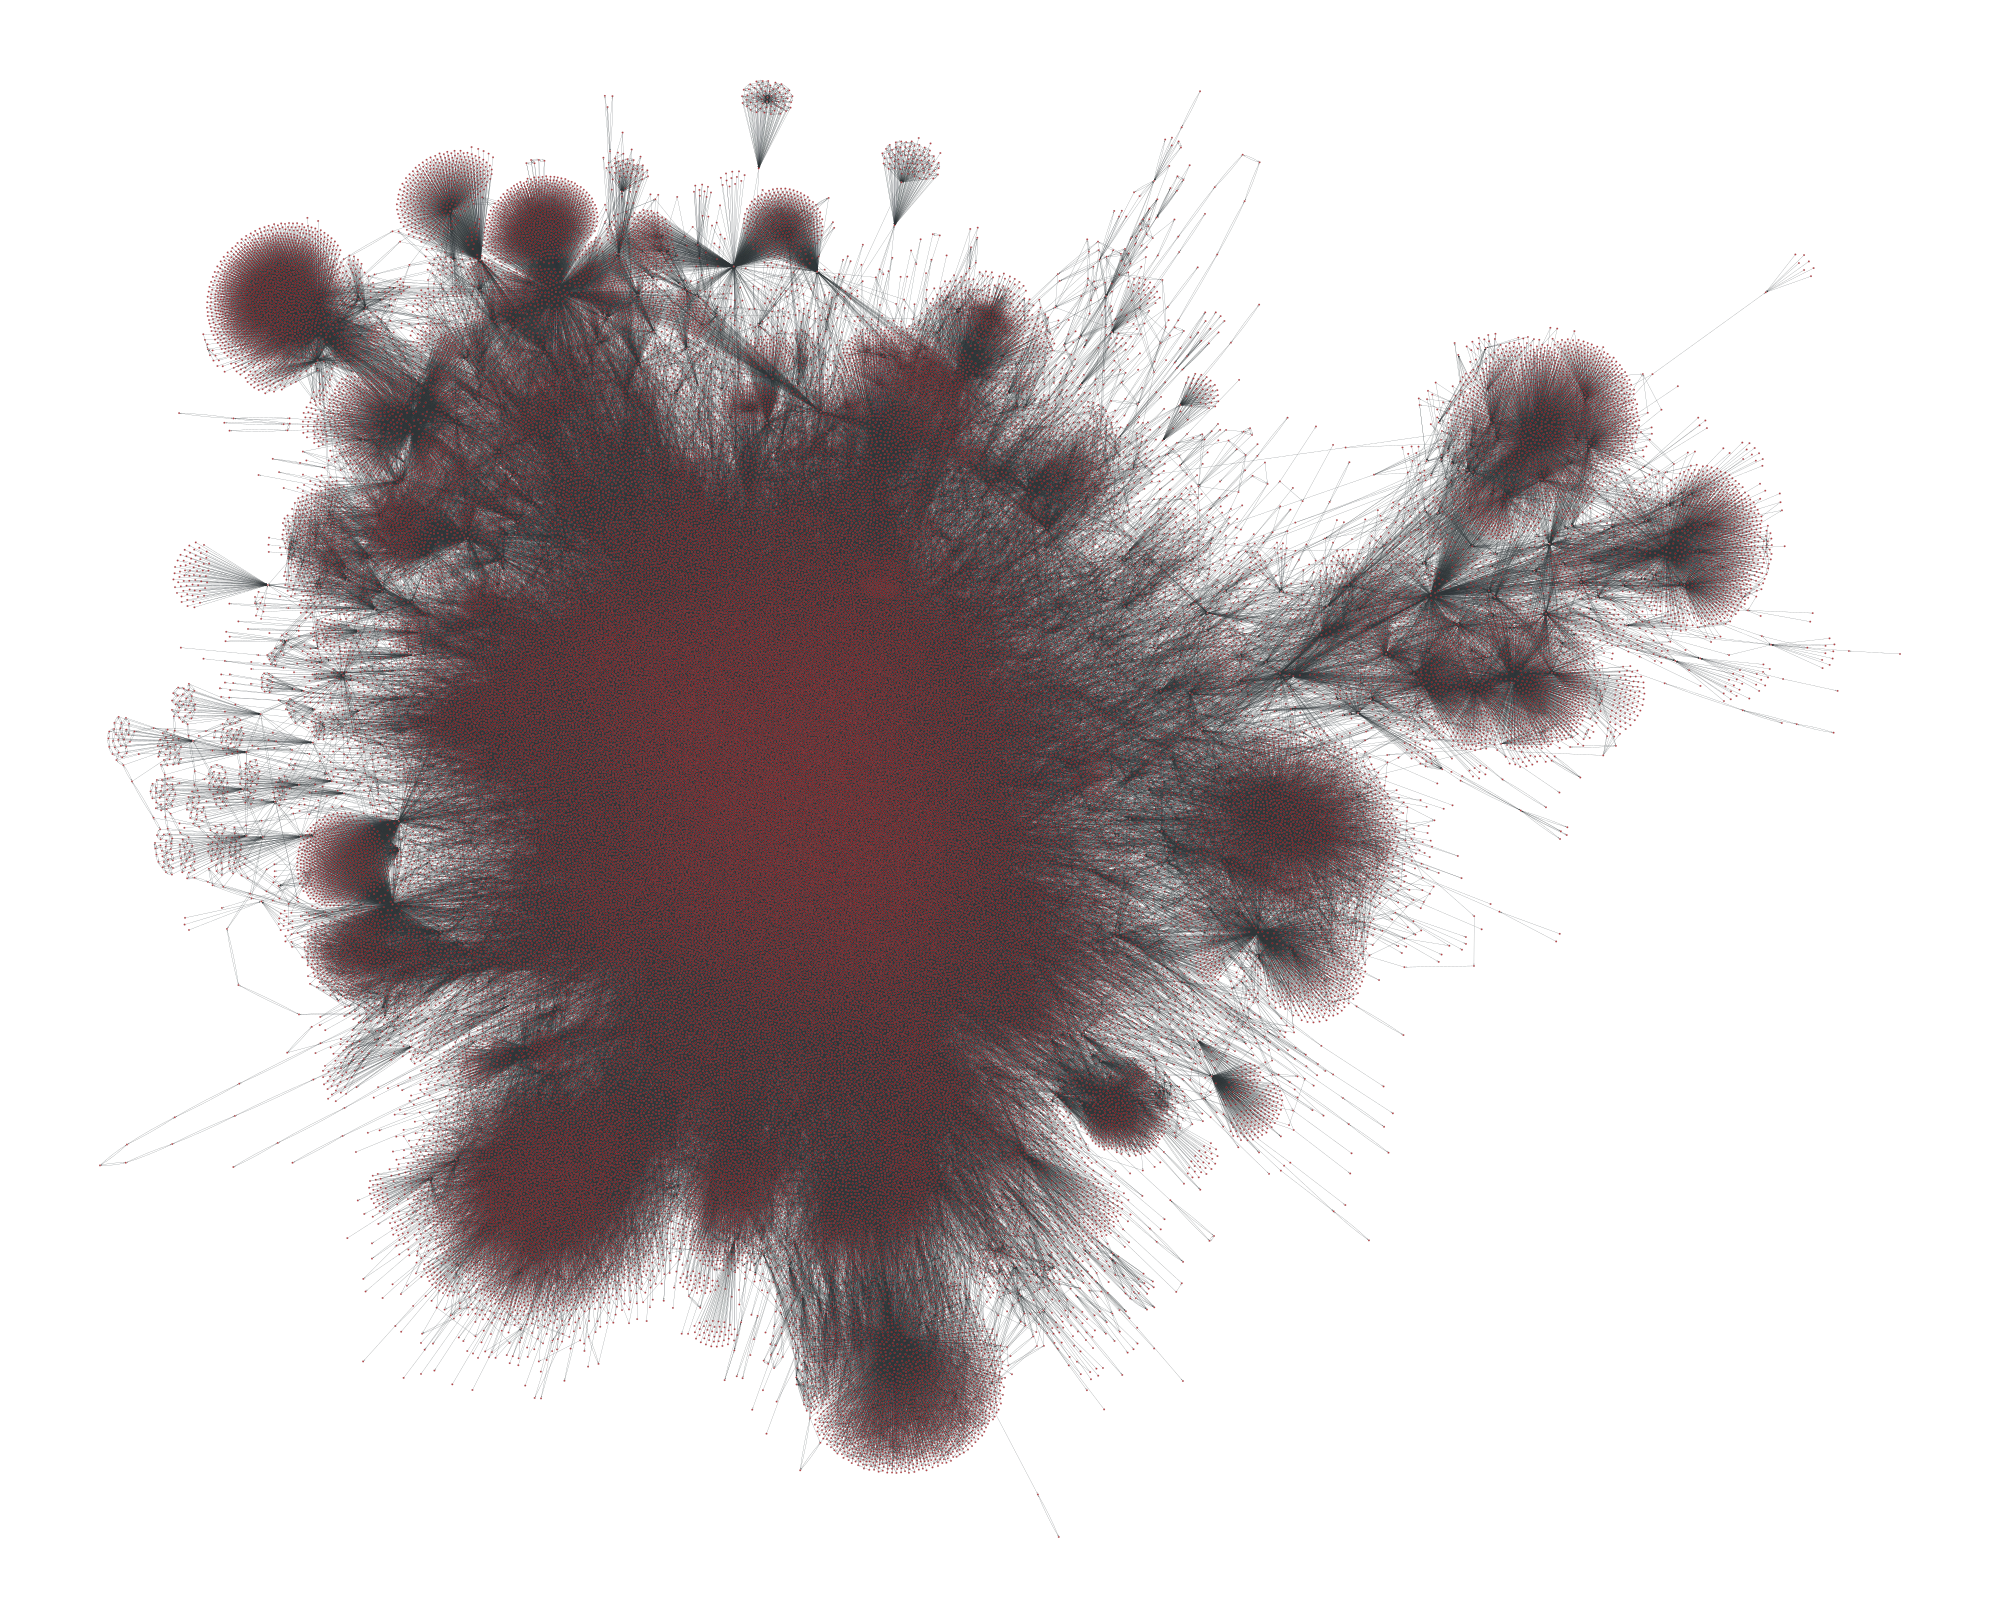

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f7ae0744d30, at 0x7f7ab02d52e0>

In [71]:
path = os.environ["TEMP"] + "/large-cluster-graph.gt"
g = load_graph(path)

pos = sfdp_layout(g)
graph_draw(g, pos=pos, output_size=(1000, 1000))

### Visualize the original graph

In [81]:
!kgtk export-gt -i $OUT/p279-graph.no.science.less-bio.tsv.gz -o $TEMP/p279-graph.no.science.less-bio.gt

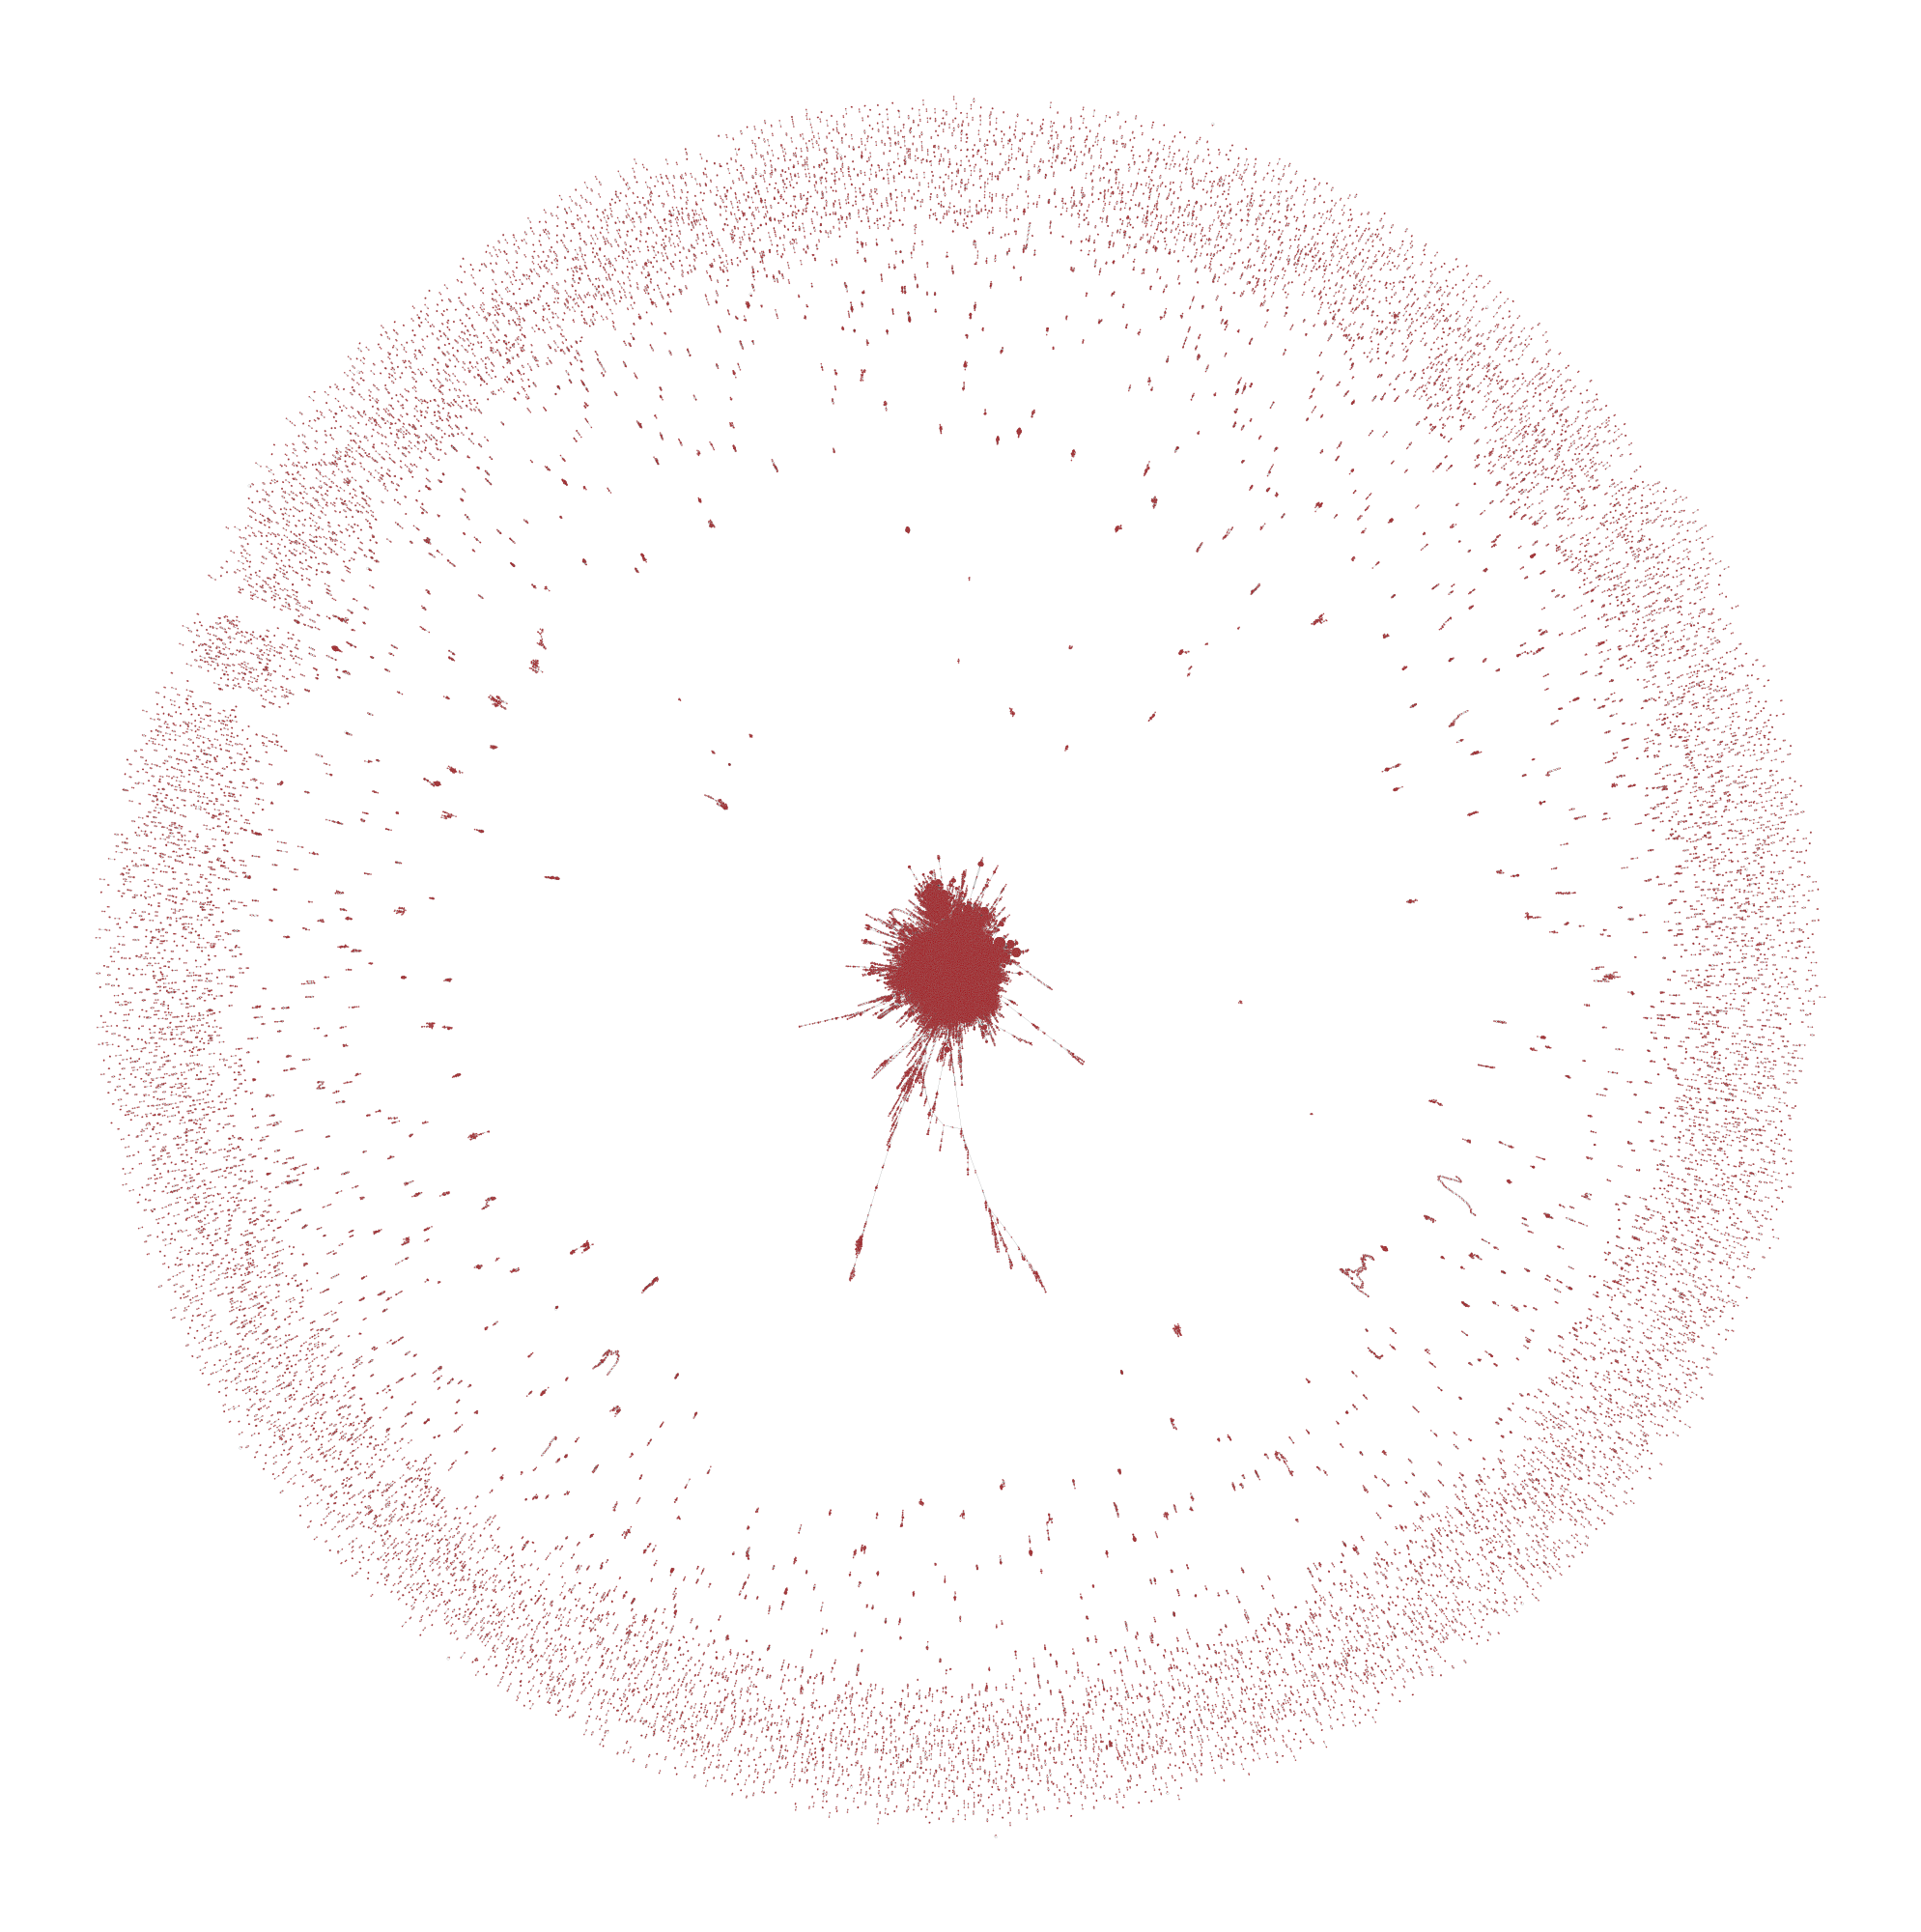

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f7a480cd850, at 0x7f7ac8ac5ca0>

In [82]:
path = os.environ["TEMP"] + "/p279-graph.no.science.less-bio.gt"
g = load_graph(path)

pos = sfdp_layout(g)
graph_draw(g, pos=pos, output_size=(1000, 1000))

## Possible next steps:
- compute embeddings in the much denser P279 graph
- use new properties to record the inherited properties so that they are not confused, as there is semantic drift when copying them down
- deploy the browser in the new graph

In [10]:
kgtk(f""" 
    graph-embeddings
        --workers 1
        -op ComplEx 
        --dimension 50 
        -ot kgtk 
        --retain_temporary_data True \
        -T $TEMP 
        -i $OUT/p279-graph.no.science.less-bio.tsv.gz \
        -o $OUT \
        --log $TEMP/ge.log.txt
""")

In Processing, Please go to /Users/pedroszekely/Downloads/kypher/projects/p279-similarity/temp.p279-similarity/ge.log.txt to check details
A subprocess exited unexpectedly with status -11

